In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
def ldx_model(t, y, ka, ke, ke_ldx, f, Vmax, Km):
    ldx_gi, ldx_p, dex_p = y

    conv = (Vmax * ldx_p) / (Km + ldx_p)

    ldx_gi_dt = -ka * ldx_gi
    ldx_p_dt = ka * ldx_gi - conv - ke_ldx * ldx_p
    dex_p_dt = f* conv - (ke * dex_p)
    
    return [ldx_gi_dt, ldx_p_dt, dex_p_dt]

In [3]:
def objective(params, V, ka, ke, ke_ldx, f, dose_ug, tmax_target, cmax_target, auc_target, w_t=10.0, w_c=1.0, w_a=1.0, eps=1e-6):
    Vmax, Km= params
    y0 = [dose_ug, 0, 0]
    t_span = (0, 72)
    t_eval = np.linspace(*t_span, 2000)
    solution = solve_ivp(
        ldx_model, t_span, y0, t_eval=t_eval, args=(ka, ke, ke_ldx, f, Vmax, Km)
    )
    t = solution.t
    dex_p = solution.y[2]
    Cdex = dex_p / V
    Cdex_ng = Cdex * 1000

    idx = np.argmax(Cdex_ng)
    tmax = t[idx]
    cmax = Cdex_ng[idx]
    auc = np.trapz(Cdex_ng, t)

    err_t = (np.log(tmax + eps) - np.log(tmax_target + eps))**2
    err_c = (np.log(cmax + eps) - np.log(cmax_target + eps))**2
    err_a = (np.log(auc + eps) - np.log(auc_target + eps))**2

    return w_t * err_t + w_c * err_c + w_a * err_a


In [4]:
from scipy.optimize import minimize, root_scalar

tmax_target = 3.78
cmax_target = 69.3
auc_target = 1020

start = [35000, 30000]

ldx_dose_mg = 70
ldx_dose_ug = ldx_dose_mg * 1000

ke = np.log(2) / 10

def tmax_equation(ka):
    return (np.log(ka) - np.log(ke)) / (ka - ke) - tmax_target

sol = root_scalar(tmax_equation, bracket=[ke + 0.01, 3], method='brentq')
ka = sol.root if sol.converged else 1.0

print(f"Estimated ka ≈ {ka:.4f} h⁻¹")

V = 195_000
ke_ldx = 0.9
f = 0.297

result = minimize(
    objective, start,
    args=(V, ka, ke, ke_ldx, f, ldx_dose_ug, tmax_target, cmax_target, auc_target),
    bounds=[(20000, 70000), (10000, 60000)],
    method='Nelder-Mead'
)

Estimated ka ≈ 0.6691 h⁻¹


In [5]:
print("Vmax:", result.x[0])
print("Km:", result.x[1])

Vmax: 60182.99234515954
Km: 10000.0


In [6]:
Vmax, Km = result.x

y0 = [70_000, 0, 0]

t_span = (0, 14)
t_eval = np.linspace(*t_span, 2000)


solution = solve_ivp(
    ldx_model, t_span, y0, t_eval=t_eval, args=(ka, ke, ke_ldx, f, Vmax, Km)
)


t = solution.t
y = solution.y

Cdex_ng = (y[2] / V) * 1000

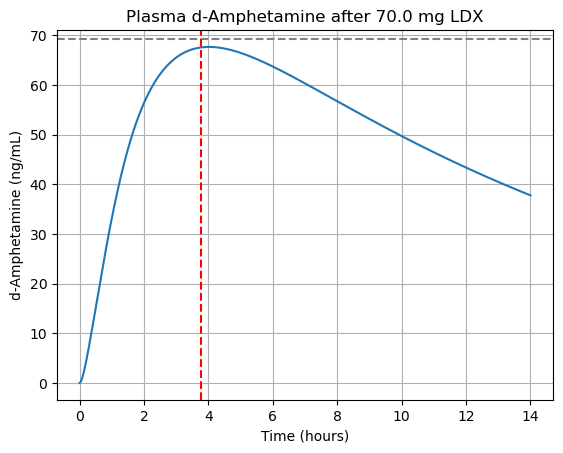

In [7]:
plt.plot(t, Cdex_ng)
plt.axhline(cmax_target, color='gray', linestyle='--', label='Cmax target')
plt.axvline(tmax_target, color='red', linestyle='--', label='Tmax target')
plt.xlabel("Time (hours)")
plt.ylabel("d-Amphetamine (ng/mL)")
plt.title(f"Plasma d-Amphetamine after {y0[0]/1000} mg LDX")
plt.grid(True)
plt.show()